# Continuous stirred tank reactor (CSTR)

In this Jupyter Notebook we illustrate the example **CSTR**.
We start by importing basic modules and **do-mpc**.

In [1]:
import numpy as np
import sys
from casadi import *

# Add do_mpc to path. This is not necessary if it was installed via pip
sys.path.append('../../../')

# Import do_mpc package:
import do_mpc

import matplotlib.pyplot as plt
import ipywidgets as widgets

In [2]:
%matplotlib notebook

## Model

In the following we will present the configuration, setup and connection between these blocks, starting with the `model`.
The considered model of the CSTR is continuous and has 4 states and 2 control inputs.
The model is initiated by:

In [3]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

Schematic diagram of CSTR system:

![CSTR_schematic](CSTR.pdf)

### States and control inputs

The four states are concentration of reactant A ($C_{\text{A}}$), the concentration of reactant B ($C_{\text{B}}$), the temperature inside the reactor ($T_{\text{R}}$) and the temperature of the cooling jacket ($T_{\text{K}}$):

In [22]:
# States struct (optimization variables):
C_a = model.set_variable(var_type='_x', var_name='C_a', shape=(1,1))
C_b = model.set_variable(var_type='_x', var_name='C_b', shape=(1,1))
T_R = model.set_variable(var_type='_x', var_name='T_R', shape=(1,1))
T_K = model.set_variable(var_type='_x', var_name='T_K', shape=(1,1))

The control inputs are the feed $F$ and the heat flow $\dot{Q}$:

In [23]:
# Input struct (optimization variables):
F = model.set_variable(var_type='_u', var_name='F')
Q_dot = model.set_variable(var_type='_u', var_name='Q_dot')

### ODE and parameters

The system model is described by the ordinary differential equation:

\begin{align}
\dot{C}_{\text{A}} &= F \cdot (C_{\text{A},0} - C_{\text{A}}) - k_1 \cdot C_{\text{A}} - k_3 \cdot C_{\text{A}}^2, \\
\dot{C}_{\text{B}} &= F \cdot C_{\text{B}} + k_1 \cdot C_{\text{A}} - k_2 \cdot C_{\text{B}}, \\
\dot{T}_{\text{R}} &= \frac{k_1 \cdot C_{\text{A}} \cdot H_{\text{R},ab} + k_2 \cdot C_{\text{B}} \cdot  H_{\text{R},bc} + k_3 \cdot C_{\text{A}}^2 \cdot H_{\text{R},ad}} {-\rho \cdot c_p}\\
&+ F \cdot (T_{\text{in}} - T_{\text{R}}) + \frac{K_w \cdot A_{\text{R}} \cdot(T_{\text{K}}-T_{\text{R}})}{\rho \cdot c_p \cdot V_{\text{R}}}, \\
\dot{T}_{\text{K}} &= \frac{\dot{Q} + k_w \cdot A_{\text{R}} \cdot T_{\text{dif}}}{m_k \cdot C_{p,k}},
\end{align}

where

\begin{align}
k_1 &= \beta \cdot k_{0,\text{ab}} \cdot \exp\left(\frac{-E_{\text{A},\text{ab}}}{T_{\text{R}}+273.15}\right), \\
k_1 &= k_{0,\text{bc}} \cdot \exp \left( \frac{-E_{\text{A},\text{bc}}}{T_{\text{R}}+273.15} \right), \\
k_3 &= k_{0,\text{ad}} \cdot \exp \left( \frac{-\alpha \cdot E_{\text{A},\text{ad}}}{T_{\text{R}}+273.15} \right).
\end{align}

The 
parameters $\alpha$ and $\beta$ are uncertain while the rest of the parameters is considered certain:

In [24]:
# Certain parameters
K0_ab = 1.287e12 # K0 [h^-1]
K0_bc = 1.287e12 # K0 [h^-1]
K0_ad = 9.043e9 # K0 [l/mol.h]
R_gas = 8.3144621e-3 # Universal gas constant
E_A_ab = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_bc = 9758.3*1.00 #* R_gas# [kj/mol]
E_A_ad = 8560.0*1.0 #* R_gas# [kj/mol]
H_R_ab = 4.2 # [kj/mol A]
H_R_bc = -11.0 # [kj/mol B] Exothermic
H_R_ad = -41.85 # [kj/mol A] Exothermic
Rou = 0.9342 # Density [kg/l]
Cp = 3.01 # Specific Heat capacity [kj/Kg.K]
Cp_k = 2.0 # Coolant heat capacity [kj/kg.k]
A_R = 0.215 # Area of reactor wall [m^2]
V_R = 10.01 #0.01 # Volume of reactor [l]
m_k = 5.0 # Coolant mass[kg]
T_in = 130.0 # Temp of inflow [Celsius]
K_w = 4032.0 # [kj/h.m^2.K]
C_A0 = (5.7+4.5)/2.0*1.0 # Concentration of A in input Upper bound 5.7 lower bound 4.5 [mol/l]

# Uncertain parameters:
alpha = model.set_variable(var_type='_p', var_name='alpha')
beta = model.set_variable(var_type='_p', var_name='beta')

# Time-varying parameters:
T_in = model.set_variable(var_type='_tvp', var_name='T_in')

In the next step, we formulate the $k_i$-s:

In [25]:
# Auxiliary terms
K_1 = beta * K0_ab * exp((-E_A_ab)/((T_R+273.15)))
K_2 =  K0_bc * exp((-E_A_bc)/((T_R+273.15)))
K_3 = K0_ad * exp((-alpha*E_A_ad)/((T_R+273.15)))

Additionally, we define an artificial variable of interest, that is not a state of the system, but can be used later:

In [26]:
T_dif = model.set_expression(expr_name='T_dif', expr=T_R-T_K)

WIth the help ot the $k_i$-s and $T_{\text{dif}}$ we can define the ODEs:

In [27]:
model.set_rhs('C_a', F*(C_A0 - C_a) -K_1*C_a - K_3*(C_a**2))
model.set_rhs('C_b', -F*C_b + K_1*C_a - K_2*C_b)
model.set_rhs('T_R', ((K_1*C_a*H_R_ab + K_2*C_b*H_R_bc + K_3*(C_a**2)*H_R_ad)/(-Rou*Cp)) + F*(T_in-T_R) +(((K_w*A_R)*(-T_dif))/(Rou*Cp*V_R)))
model.set_rhs('T_K', (Q_dot + K_w*A_R*(T_dif))/(m_k*Cp_k))

We also define an additional time-varying parameter to be used in the controller. We aim to change the set-point for the concentration of $C_A$ and therefore introduce:

In [28]:
C_b_set = model.set_variable(var_type='_tvp', var_name='C_b_set')

Finally, the model setup is completed:

In [29]:
# Build the model
model.setup()

## Controller


Next, the model predictive controller is configured.
First, one member of the mpc class is generated with the prediction model defined above:

In [72]:
mpc = do_mpc.controller.MPC(model)

We choose the prediction horizon `n_horizon`, set the robust horizon `n_robust` to 1. The time step `t_step` is set to one second and parameters of the applied discretization scheme orthogonal collocation are as seen below:

In [73]:
setup_mpc = {
    'n_horizon': 20,
    'n_robust': 1,
    'open_loop': 0,
    't_step': 0.005,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 2,
    'collocation_ni': 2,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'MA27'}
}

mpc.set_param(**setup_mpc)

Because the magnitude of the states and inputs is very different, we introduce scaling factors:

In [74]:
mpc.scaling['_x', 'T_R'] = 100
mpc.scaling['_x', 'T_K'] = 100
mpc.scaling['_u', 'Q_dot'] = 2000
mpc.scaling['_u', 'F'] = 100

### Objective

The goal of the CSTR is to obtain a mixture with a set concentration of $C_{\text{B,set}}$. The concrete value will change over time, which is why we use the previously defined time-varying parameters as a placeholder here.
Additionally, we add a penalty on input changes for both control inputs, to obtain a smooth control performance.

In [75]:
mterm = (model.x['C_b'] - model.tvp['C_b_set'])**2 # terminal cost
lterm = (model.x['C_b'] - model.tvp['C_b_set'])**2 # stage cost

mpc.set_objective(mterm=mterm, lterm=lterm)

mpc.set_rterm(F=0.1, Q_dot = 1e-3) # input penalty

### Constraints

In the next step, the constraints of the control problem are set.
In this case, there are only upper and lower bounds for each state and the input:

In [76]:
# lower bounds of the states
mpc.bounds['lower', '_x', 'C_a'] = 0.1
mpc.bounds['lower', '_x', 'C_b'] = 0.1
mpc.bounds['lower', '_x', 'T_R'] = 50
mpc.bounds['lower', '_x', 'T_K'] = 50

# upper bounds of the states
mpc.bounds['upper', '_x', 'C_a'] = 2
mpc.bounds['upper', '_x', 'C_b'] = 2
mpc.bounds['upper', '_x', 'T_K'] = 140

# lower bounds of the inputs
mpc.bounds['lower', '_u', 'F'] = 5
mpc.bounds['lower', '_u', 'Q_dot'] = -8500

# upper bounds of the inputs
mpc.bounds['upper', '_u', 'F'] = 100
mpc.bounds['upper', '_u', 'Q_dot'] = 0.0

If a constraint is not critical, it is possible to implement it as a **soft** constraint.
This means, that a small violation of the constraint does not render the optimization infeasible.
Instead, a penalty term is added to the objective.
**Soft** constraints can always be applied, if small violations can be accepted and it might even be necessary to apply MPC in a safe way (by avoiding avoiding numerical instabilities).
In this case, we define the upper bounds of the reactor temperature as a **soft** constraint by using `mpc.set_nl_cons()`.

In [77]:
mpc.set_nl_cons('T_R', model.x['T_R'], ub=140, soft_constraint=True, penalty_term_cons=1e2)

SX(T_R)

### Time-varying parameters

The control objective is to track a certain concentration for the product $C_b$ for which we have introduced in the model the time-varying parameter ``C_b_set``. During runtime, we must choose concrete values for this parameter. 

The same holds for the inlet temperature ``T_in``, for which we assume a known profile`

Setting values to time-varying parameters is **a two-step process**: First, we obtain a structure that is based on our model definition and then we pass a function that is called at each controller iteration and which changes values in this structure.

In [78]:
tvp_struct_mpc = mpc.get_tvp_template()

To understand this structure better, it helps to query the ``labels``:

In [79]:
tvp_struct_mpc.labels()[:5]

['[_tvp,0,T_in,0]',
 '[_tvp,0,C_b_set,0]',
 '[_tvp,1,T_in,0]',
 '[_tvp,1,C_b_set,0]',
 '[_tvp,2,T_in,0]']

By default all values in this structure are initialized with zero:

In [80]:
tvp_struct_mpc['_tvp',0,'T_in']

DM(0)

Let's set some better default values:

In [81]:
tvp_struct_mpc['_tvp',:,'T_in'] = 130

We now want to set new values for all indices of the structure at each iteration. For this purpose we need to define a function that takes as input the current time and returns as output the structure:

```python
def tvp_fun_mpc(t_now):
    # Set values of tvp_struct_mpc
    
    return tvp_struct_mpc
```

In [82]:
def tvp_fun_mpc(t_now):
    if t_now <= 0.1:
        tvp_struct_mpc['_tvp',:,'C_b_set'] = 0.6
    else:
        tvp_struct_mpc['_tvp',:,'C_b_set'] = 0.5
        
    return tvp_struct_mpc

Finally, we need to pass the newly created function to the MPC instance:

In [83]:
mpc.set_tvp_fun(tvp_fun_mpc)

### Uncertain values

The explicit values of the two uncertain parameters $\alpha$ and $\beta$, which are considered in the scenario tree, are given by:

In [84]:
alpha_var = np.array([1., 1.05, 0.95])
beta_var = np.array([1., 1.1, 0.9])

mpc.set_uncertainty_values(alpha = alpha_var, beta = beta_var)

This means with `n_robust=1`, that 9 different scenarios are considered.
The setup of the MPC controller is concluded by:

In [85]:
mpc.setup()

## Estimator

We assume, that all states can be directly measured (state-feedback):

In [86]:
estimator = do_mpc.estimator.StateFeedback(model)

## Simulator

To create a simulator in order to run the MPC in a closed-loop, we create an instance of the **do-mpc** simulator which is based on the same model:

In [87]:
simulator = do_mpc.simulator.Simulator(model)

For the simulation, we use the same time step `t_step` as for the optimizer:

In [88]:
params_simulator = {
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 0.005
}

simulator.set_param(**params_simulator)

### Realizations of uncertain parameters

For the simulation, it is necessary to define the numerical realizations of the uncertain parameters in `p_struct_sim` and the time-varying parameters in `tvp_struct_sim`.
This works similar but not identical as for the MPC controller. 
The main difference is that the simulator is always evaluated with exact values of the uncertain parameters and only needs a single time-varying parameter (instead of a trajectory covering the prediction horizon).

First, we get the structure of the uncertain and time-varying parameters:

In [89]:
p_struct_sim = simulator.get_p_template()
tvp_struct_sim = simulator.get_tvp_template()

We define two functions which are called in each simulation step, which return the current realizations of the parameters, with respect to defined inputs (in this case `t_now`).

Note that the struct for the time-varying parameters contains the setpoint ``C_b_set``. This parameter has no influence on the simulator and thus we don't need to change the dafault value of zero.

In [90]:
# function for time-varying parameters
tvp_struct_sim['T_in'] = 130

def tvp_fun(t_now):
    return tvp_struct_sim

# uncertain parameters
p_struct_sim['alpha'] = 1
p_struct_sim['beta'] = 1
def p_fun(t_now):
    return p_struct_sim

These two custum functions are used in the simulation via:

In [91]:
simulator.set_tvp_fun(tvp_fun)
simulator.set_p_fun(p_fun)

By defining `p_fun` as above, the function will always return the value 1.0 for both $\alpha$ and $\beta$.
To finish the configuration of the simulator, call:

In [92]:
simulator.setup()

## Closed-loop simulation

For the simulation of the MPC configured for the CSTR, we inspect the file **main.py**.
We define the initial state of the system and set it for all parts of the closed-loop configuration:

In [93]:
mpc.x0['C_a'] = 0.8 # This is the initial concentration inside the tank [mol/l]
mpc.x0['C_b'] = 0.5 # This is the controlled variable [mol/l]
mpc.x0['T_R'] = 134.14 #[C]
mpc.x0['T_K'] = 130 #[C]

x0 = mpc.x0

simulator.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

Now, we simulate the closed-loop for 50 steps (and suppress the output of the cell with the magic command `%%capture`):

In [94]:
N_sim = 50
for k in range(N_sim):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)

This is Ipopt version 3.12.3, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    20884
Number of nonzeros in inequality constraint Jacobian.:      360
Number of nonzeros in Lagrangian Hessian.............:     5907

Total number of variables............................:     5832
                     variables with only lower bounds:     1386
                variables with lower and upper bounds:     3978
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5044
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8021301e+02 7.82e-02 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1

Total number of variables............................:     5832
                     variables with only lower bounds:     1386
                variables with lower and upper bounds:     3978
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5044
Total number of inequality constraints...............:      180
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      180

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8000414e+02 1.42e-02 9.90e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1  1.6902214e+02 1.41e-02 7.91e+01  -1.0 8.90e-01  -4.0 2.03e-01 1.11e-02f  1
   2  1.2422041e+02 2.71e-03 2.55e+01  -1.0 4.04e+00  -4.5 6.79e-01 9.97e-01f  1
   3  1.6331916e+02 5.54e-03 1.17e+01  -1.0 1.74e+00  -5.0 5.40e-01 9.57e-01f  1
   4  1.5484689e+0

  27  1.9092033e-03 9.95e-08 6.75e-11  -9.0 4.50e+02 -16.4 1.00e+00 1.00e+00h  1
  28  1.9092033e-03 2.05e-11 2.64e-14  -9.0 1.32e+03 -16.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 28

                                   (scaled)                 (unscaled)
Objective...............:   2.1213370311138897e-04    1.9092033280025008e-03
Dual infeasibility......:   2.6389828387584220e-14    2.3750845548825797e-13
Constraint violation....:   2.0524526522791575e-11    2.0524526522791575e-11
Complementarity.........:   9.0910782681597185e-10    8.1819704413437466e-09
Overall NLP error.......:   9.0910782681597185e-10    8.1819704413437466e-09


Number of objective function evaluations             = 29
Number of objective gradient evaluations             = 29
Number of equality constraint evaluations            = 29
Number of inequality constraint evaluations          = 29
Number of equality constraint Jacobian evaluations   = 29
Number of inequality constraint Jacobian evaluations = 29
N

  20  3.0106925e-03 1.05e-03 4.31e-05  -8.6 2.58e+00 -13.1 6.52e-01 1.00e+00h  1
  21  2.5009748e-03 6.30e-04 2.21e-05  -8.6 2.14e+00 -13.5 7.02e-01 3.90e-01h  1
  22  2.0790496e-03 4.45e-04 9.85e-06  -8.6 4.55e+00 -14.0 7.84e-01 5.36e-01h  1
  23  1.9109685e-03 3.17e-04 3.55e-06  -8.6 1.37e+01 -14.5 9.98e-01 6.34e-01h  1
  24  1.8702652e-03 9.17e-05 6.39e-08  -8.6 4.15e+01 -15.0 1.00e+00 1.00e+00h  1
  25  1.8695345e-03 6.81e-07 5.04e-10  -8.6 1.24e+02 -15.5 1.00e+00 1.00e+00h  1
  26  1.8695279e-03 1.00e-09 5.96e-13  -8.6 3.66e+02 -15.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 26

                                   (scaled)                 (unscaled)
Objective...............:   2.0772532258433353e-04    1.8695279032590018e-03
Dual infeasibility......:   5.9640862580951285e-13    5.3676776322856156e-12
Constraint violation....:   9.9957122808892740e-10    9.9957122808892740e-10
Complementarity.........:   2.5070217043374853e-09    2.2563195339037369e-08
Overall NLP error......

   7  5.6442268e+00 1.09e-06 7.27e-03  -2.5 3.44e-01  -6.9 1.00e+00 1.00e+00f  1
   8  1.1441520e+00 8.96e-04 6.31e-03  -3.8 3.98e-01  -7.3 9.22e-01 1.00e+00f  1
   9  5.4152746e-01 7.87e-03 1.68e-03  -3.8 2.20e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2148290e-01 3.75e-03 1.07e-04  -3.8 1.13e+00  -8.3 1.00e+00 1.00e+00h  1
  11  4.2492387e-01 2.80e-06 1.58e-07  -3.8 1.48e+00  -8.8 1.00e+00 1.00e+00h  1
  12  6.7775084e-02 6.29e-03 1.37e-03  -5.7 1.48e+00  -9.2 5.78e-01 1.00e+00f  1
  13  3.3497386e-02 4.64e-03 1.18e-03  -5.7 8.99e-01  -9.7 5.32e-01 1.00e+00h  1
  14  2.1520492e-02 2.51e-03 8.40e-04  -5.7 7.65e-01 -10.2 5.26e-01 1.00e+00h  1
  15  1.5215807e-02 9.97e-04 4.77e-04  -5.7 1.47e+00 -10.7 5.66e-01 1.00e+00h  1
  16  1.1523537e-02 4.49e-04 1.70e-04  -5.7 4.42e+00 -11.2 6.92e-01 1.00e+00h  1
  17  9.3101386e-03 2.58e-04 5.01e-07  -5.7 1.32e+01 -11.6 1.00e+00 1.00e+00h  1
  18  8.3576518e-03 8.41e-05

   9  4.5454339e-01 1.75e-03 1.57e-04  -3.8 8.88e-01  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2296596e-01 8.46e-04 9.16e-06  -3.8 4.62e-01  -8.3 1.00e+00 1.00e+00h  1
  11  6.5716757e-02 6.36e-03 1.42e-03  -5.7 1.46e+00  -8.8 5.53e-01 1.00e+00h  1
  12  3.2999148e-02 4.38e-03 1.27e-03  -5.7 7.95e-01  -9.2 4.91e-01 1.00e+00h  1
  13  2.1793179e-02 2.26e-03 8.45e-04  -5.7 6.46e-01  -9.7 5.38e-01 1.00e+00h  1
  14  1.5337349e-02 1.07e-03 4.83e-04  -5.7 8.45e-01 -10.2 5.66e-01 1.00e+00h  1
  15  1.1479420e-02 4.46e-04 1.97e-04  -5.7 1.38e+00 -10.7 6.57e-01 1.00e+00h  1
  16  9.2446531e-03 2.65e-04 7.05e-07  -5.7 4.13e+00 -11.2 1.00e+00 1.00e+00h  1
  17  8.0846450e-03 1.18e-04 1.04e-07  -5.7 1.24e+01 -11.6 1.00e+00 1.00e+00h  1
  18  8.1456100e-03 9.78e-07 7.58e-10  -5.7 3.71e+01 -12.1 1.00e+00 1.00e+00h  1
  19  2.8164381e-03 9.80e-04 4.29e-05  -8.6 2.44e+00 -12.6 6.52e-01 1.00e+00h  1
iter    objective    inf_pr 

   9  4.4932797e-01 1.92e-03 1.62e-04  -3.8 9.28e-01  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.2033182e-01 7.89e-04 8.62e-06  -3.8 4.50e-01  -8.3 1.00e+00 1.00e+00h  1
  11  6.3762941e-02 6.40e-03 1.45e-03  -5.7 1.46e+00  -8.8 5.40e-01 1.00e+00h  1
  12  3.2099750e-02 4.28e-03 1.26e-03  -5.7 7.28e-01  -9.2 4.93e-01 1.00e+00h  1
  13  2.1161014e-02 2.25e-03 8.46e-04  -5.7 6.06e-01  -9.7 5.33e-01 1.00e+00h  1
  14  1.4917712e-02 1.08e-03 4.66e-04  -5.7 7.93e-01 -10.2 5.81e-01 1.00e+00h  1
  15  1.1085832e-02 4.43e-04 1.93e-04  -5.7 1.34e+00 -10.7 6.57e-01 1.00e+00h  1
  16  8.9361236e-03 2.59e-04 2.18e-06  -5.7 4.02e+00 -11.2 9.89e-01 1.00e+00h  1
  17  7.8511157e-03 1.08e-04 9.71e-08  -5.7 1.20e+01 -11.6 1.00e+00 1.00e+00h  1
  18  7.8962488e-03 7.03e-07 5.67e-10  -5.7 3.61e+01 -12.1 1.00e+00 1.00e+00h  1
  19  2.7159188e-03 9.44e-04 4.32e-05  -8.6 2.36e+00 -12.6 6.53e-01 1.00e+00h  1
iter    objective    inf_pr 

   1  1.6910029e+02 4.22e-04 5.93e+01  -1.0 1.34e+00  -4.0 4.07e-01 1.12e-02f  1
   2  1.4181253e+02 3.38e-03 1.78e+01  -1.0 3.42e+00  -4.5 7.02e-01 9.76e-01f  1
   3  1.5801917e+02 8.05e-03 6.80e+00  -1.0 2.28e+00  -5.0 6.16e-01 1.00e+00f  1
   4  1.5538180e+02 3.93e-03 1.87e-01  -1.0 3.29e+00  -5.4 9.90e-01 1.00e+00f  1
   5  1.5562375e+02 2.05e-03 1.17e-01  -1.0 2.09e+00  -5.9 9.94e-01 1.00e+00f  1
   6  3.2152048e+01 1.12e-06 4.69e-03  -1.7 7.25e-01  -6.4 1.00e+00 1.00e+00f  1
   7  1.2686892e+00 2.78e-05 8.06e-03  -3.8 5.64e-02  -6.9 9.88e-01 1.00e+00f  1
   8  6.2388180e-01 1.34e-02 3.54e-03  -3.8 2.32e+00  -7.3 3.49e-01 1.00e+00f  1
   9  4.4617679e-01 2.00e-03 1.64e-04  -3.8 9.30e-01  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.1860263e-01 7.53e-04 8.26e-06  -3.8 4.42e-01  -8.3 1.00e+00 1.00e+00h  1
  11  6.2533989e-02 6.41e-03 1.46e-03  -5.7 1.46e+00  -8.8 5.35e-01 1.00e+00h  1
  12  3.1444770e-02 4.24e-03

   9  9.7189903e-01 1.28e-02 3.70e-03  -3.8 3.10e+00  -7.8 4.71e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  6.4101638e-01 3.23e-03 2.50e-04  -3.8 1.35e+00  -8.3 1.00e+00 1.00e+00h  1
  11  5.8047017e-01 1.15e-03 1.52e-05  -3.8 1.27e+00  -8.8 1.00e+00 1.00e+00h  1
  12  1.1615649e-01 9.14e-03 1.53e-03  -5.7 1.92e+00  -9.2 5.40e-01 1.00e+00h  1
  13  7.5233724e-02 5.58e-03 8.96e-04  -5.7 8.73e-01  -9.7 5.13e-01 6.13e-01h  1
  14  4.4791879e-02 4.70e-03 1.37e-03  -5.7 8.21e-01 -10.2 4.94e-01 1.00e+00h  1
  15  3.6339568e-02 1.54e-03 8.63e-04  -5.7 1.26e+00 -10.7 6.08e-01 1.00e+00h  1
  16  3.2250028e-02 4.35e-04 3.64e-04  -5.7 3.78e+00 -11.2 7.13e-01 1.00e+00h  1
  17  3.0181051e-02 2.27e-04 1.21e-06  -5.7 1.13e+01 -11.6 1.00e+00 1.00e+00h  1
  18  2.9333981e-02 5.99e-05 1.61e-07  -5.7 3.40e+01 -12.1 1.00e+00 1.00e+00h  1
  19  2.9370731e-02 4.74e-07 1.27e-09  -5.7 1.01e+02 -12.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  10  6.3999611e-01 4.10e-03 3.94e-04  -3.8 1.87e+00  -8.3 1.00e+00 1.00e+00h  1
  11  5.5139888e-01 1.75e-03 2.35e-05  -3.8 1.08e+00  -8.8 1.00e+00 1.00e+00h  1
  12  5.5204004e-01 1.18e-06 5.54e-08  -3.8 3.25e+00  -9.2 1.00e+00 1.00e+00h  1
  13  9.2616859e-02 9.10e-03 1.56e-03  -5.7 1.93e+00  -9.7 5.29e-01 1.00e+00f  1
  14  3.6916201e-02 5.36e-03 1.52e-03  -5.7 8.76e-01 -10.2 5.14e-01 1.00e+00h  1
  15  2.0888572e-02 2.99e-03 1.24e-03  -5.7 1.07e+00 -10.7 5.60e-01 1.00e+00h  1
  16  1.3680867e-02 1.33e-03 8.33e-04  -5.7 3.22e+00 -11.2 5.97e-01 1.00e+00h  1
  17  1.0091717e-02 4.02e-04 3.04e-04  -5.7 9.66e+00 -11.6 7.42e-01 1.00e+00h  1
  18  8.1157390e-03 2.36e-04 1.04e-06  -5.7 2.90e+01 -12.1 1.00e+00 1.00e+00h  1
  19  7.4378003e-03 4.34e-05 1.02e-07  -5.7 8.66e+01 -12.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  7.4628713e-03 2.14e-07 5.59e-10  -5.7 2.57e+02 -13.1 1.00e+00 1.00e+00h  1
  21  2.5852077e-03 8.47e-04

   3  1.5774211e+02 1.19e-02 6.27e+00  -1.0 2.31e+00  -5.0 6.18e-01 1.00e+00f  1
   4  1.5627091e+02 6.01e-03 2.20e-01  -1.0 3.15e+00  -5.4 9.90e-01 1.00e+00f  1
   5  1.5653961e+02 2.03e-03 9.38e-02  -1.0 1.61e+00  -5.9 9.93e-01 1.00e+00f  1
   6  3.3044012e+01 1.05e-06 9.79e-03  -1.7 5.34e-01  -6.4 1.00e+00 1.00e+00f  1
   7  2.1443841e+00 3.12e-05 1.81e-02  -3.8 8.96e-02  -6.9 9.72e-01 1.00e+00f  1
   8  1.2481333e+00 9.69e-03 4.19e-03  -3.8 2.28e+00  -7.3 6.76e-01 1.00e+00f  1
   9  6.6570506e-01 6.98e-03 6.73e-04  -3.8 2.42e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4875790e-01 2.54e-03 3.67e-05  -3.8 8.51e-01  -8.3 1.00e+00 1.00e+00h  1
  11  5.4924107e-01 2.04e-06 1.18e-07  -3.8 9.77e-01  -8.8 1.00e+00 1.00e+00h  1
  12  9.1633891e-02 9.06e-03 1.55e-03  -5.7 1.93e+00  -9.2 5.36e-01 1.00e+00f  1
  13  3.5485928e-02 5.45e-03 1.52e-03  -5.7 8.77e-01  -9.7 5.15e-01 1.00e+00h  1
  14  1.9462872e-02 3.05e-03

   3  1.5772342e+02 1.19e-02 6.21e+00  -1.0 2.26e+00  -5.0 6.26e-01 1.00e+00f  1
   4  1.5627836e+02 6.27e-03 2.06e-01  -1.0 3.15e+00  -5.4 9.90e-01 1.00e+00f  1
   5  1.5654286e+02 2.10e-03 9.54e-02  -1.0 1.60e+00  -5.9 9.93e-01 1.00e+00f  1
   6  3.3040522e+01 1.04e-06 9.36e-03  -1.7 5.06e-01  -6.4 1.00e+00 1.00e+00f  1
   7  2.1432659e+00 3.15e-05 1.78e-02  -3.8 9.05e-02  -6.9 9.72e-01 1.00e+00f  1
   8  1.2453022e+00 9.80e-03 4.23e-03  -3.8 2.31e+00  -7.3 6.64e-01 1.00e+00f  1
   9  6.6897812e-01 6.79e-03 6.64e-04  -3.8 2.40e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4895463e-01 2.62e-03 3.82e-05  -3.8 8.76e-01  -8.3 1.00e+00 1.00e+00h  1
  11  5.4925303e-01 2.08e-06 1.21e-07  -3.8 9.25e-01  -8.8 1.00e+00 1.00e+00h  1
  12  9.1633693e-02 9.01e-03 1.54e-03  -5.7 1.94e+00  -9.2 5.42e-01 1.00e+00f  1
  13  3.5148403e-02 5.54e-03 1.51e-03  -5.7 8.84e-01  -9.7 5.19e-01 1.00e+00h  1
  14  1.9101451e-02 3.12e-03

   1  1.6909660e+02 2.76e-03 5.26e+01  -1.0 1.12e+00  -4.0 4.78e-01 1.12e-02f  1
   2  1.4487884e+02 7.02e-03 1.69e+01  -1.0 3.32e+00  -4.5 6.80e-01 9.79e-01f  1
   3  1.5772284e+02 1.18e-02 6.20e+00  -1.0 2.20e+00  -5.0 6.34e-01 1.00e+00f  1
   4  1.5628038e+02 6.50e-03 2.11e-01  -1.0 3.15e+00  -5.4 9.90e-01 1.00e+00f  1
   5  1.5654395e+02 2.04e-03 9.42e-02  -1.0 1.62e+00  -5.9 9.93e-01 1.00e+00f  1
   6  3.3035341e+01 1.04e-06 9.65e-03  -1.7 4.48e-01  -6.4 1.00e+00 1.00e+00f  1
   7  2.1402115e+00 3.25e-05 1.78e-02  -3.8 9.13e-02  -6.9 9.72e-01 1.00e+00f  1
   8  1.2512496e+00 9.50e-03 4.29e-03  -3.8 2.30e+00  -7.3 6.59e-01 1.00e+00f  1
   9  6.7347572e-01 6.78e-03 6.68e-04  -3.8 2.40e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4873701e-01 2.73e-03 4.08e-05  -3.8 9.08e-01  -8.3 1.00e+00 1.00e+00h  1
  11  5.4887814e-01 2.18e-06 1.29e-07  -3.8 8.20e-01  -8.8 1.00e+00 1.00e+00h  1
  12  9.1588572e-02 8.96e-03

   1  1.6909137e+02 3.55e-03 5.23e+01  -1.0 1.12e+00  -4.0 4.80e-01 1.12e-02f  1
   2  1.4506339e+02 7.02e-03 1.66e+01  -1.0 3.34e+00  -4.5 6.83e-01 9.72e-01f  1
   3  1.5765959e+02 1.20e-02 6.07e+00  -1.0 2.19e+00  -5.0 6.37e-01 1.00e+00f  1
   4  1.5629071e+02 6.67e-03 2.07e-01  -1.0 3.15e+00  -5.4 9.90e-01 1.00e+00f  1
   5  1.5654304e+02 1.92e-03 8.92e-02  -1.0 1.56e+00  -5.9 9.93e-01 1.00e+00f  1
   6  3.3028838e+01 9.59e-07 9.68e-03  -1.7 4.31e-01  -6.4 1.00e+00 1.00e+00f  1
   7  2.1359418e+00 3.27e-05 1.76e-02  -3.8 9.21e-02  -6.9 9.72e-01 1.00e+00f  1
   8  1.2496492e+00 9.43e-03 4.33e-03  -3.8 2.32e+00  -7.3 6.49e-01 1.00e+00f  1
   9  6.7655072e-01 6.63e-03 6.62e-04  -3.8 2.39e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4860411e-01 2.81e-03 4.25e-05  -3.8 9.35e-01  -8.3 1.00e+00 1.00e+00h  1
  11  5.4859672e-01 2.21e-06 1.33e-07  -3.8 7.89e-01  -8.8 1.00e+00 1.00e+00h  1
  12  9.1608246e-02 8.91e-03

   8  1.2485120e+00 9.37e-03 4.37e-03  -3.8 2.34e+00  -7.3 6.39e-01 1.00e+00f  1
   9  6.7964989e-01 6.50e-03 6.56e-04  -3.8 2.38e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4853826e-01 2.88e-03 4.43e-05  -3.8 9.62e-01  -8.3 1.00e+00 1.00e+00h  1
  11  5.4839344e-01 2.22e-06 1.36e-07  -3.8 7.69e-01  -8.8 1.00e+00 1.00e+00h  1
  12  9.1651408e-02 8.86e-03 1.52e-03  -5.7 1.98e+00  -9.2 5.58e-01 1.00e+00f  1
  13  3.4276506e-02 5.81e-03 1.47e-03  -5.7 9.00e-01  -9.7 5.33e-01 1.00e+00h  1
  14  1.8075280e-02 3.36e-03 1.28e-03  -5.7 8.19e-01 -10.2 5.71e-01 1.00e+00h  1
  15  1.1316641e-02 1.36e-03 7.97e-04  -5.7 1.08e+00 -10.7 6.37e-01 1.00e+00h  1
  16  8.0764335e-03 4.41e-04 2.13e-04  -5.7 2.29e+00 -11.2 8.12e-01 1.00e+00h  1
  17  6.3659071e-03 2.27e-04 1.05e-06  -5.7 6.87e+00 -11.6 1.00e+00 1.00e+00h  1
  18  6.0578561e-03 1.55e-05 2.63e-08  -5.7 2.06e+01 -12.1 1.00e+00 1.00e+00h  1
  19  1.3534022e-03 8.12e-04

   1  1.6908360e+02 4.69e-03 5.19e+01  -1.0 1.11e+00  -4.0 4.83e-01 1.12e-02f  1
   2  1.4534879e+02 7.02e-03 1.57e+01  -1.0 3.37e+00  -4.5 6.98e-01 9.63e-01f  1
   3  1.5750944e+02 1.26e-02 5.75e+00  -1.0 2.25e+00  -5.0 6.36e-01 1.00e+00f  1
   4  1.5631693e+02 6.82e-03 1.95e-01  -1.0 3.14e+00  -5.4 9.90e-01 1.00e+00f  1
   5  1.5654187e+02 1.70e-03 7.92e-02  -1.0 1.42e+00  -5.9 9.93e-01 1.00e+00f  1
   6  3.3019466e+01 7.65e-07 9.46e-03  -1.7 4.16e-01  -6.4 1.00e+00 1.00e+00f  1
   7  2.1300298e+00 3.32e-05 1.73e-02  -3.8 9.33e-02  -6.9 9.72e-01 1.00e+00f  1
   8  1.2478747e+00 9.33e-03 4.40e-03  -3.8 2.35e+00  -7.3 6.33e-01 1.00e+00f  1
   9  6.8166924e-01 6.41e-03 6.52e-04  -3.8 2.37e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4850022e-01 2.93e-03 4.54e-05  -3.8 9.80e-01  -8.3 1.00e+00 1.00e+00h  1
  11  5.4827184e-01 2.23e-06 1.37e-07  -3.8 7.61e-01  -8.8 1.00e+00 1.00e+00h  1
  12  9.1686372e-02 8.83e-03

   1  1.6907963e+02 5.33e-03 5.18e+01  -1.0 1.10e+00  -4.0 4.85e-01 1.12e-02f  1
   2  1.4547645e+02 7.02e-03 1.53e+01  -1.0 3.38e+00  -4.5 7.05e-01 9.59e-01f  1
   3  1.5744245e+02 1.29e-02 5.59e+00  -1.0 2.28e+00  -5.0 6.36e-01 1.00e+00f  1
   4  1.5632923e+02 6.89e-03 1.89e-01  -1.0 3.13e+00  -5.4 9.90e-01 1.00e+00f  1
   5  1.5654121e+02 1.60e-03 7.45e-02  -1.0 1.35e+00  -5.9 9.93e-01 1.00e+00f  1
   6  3.3014294e+01 6.80e-07 9.33e-03  -1.7 4.09e-01  -6.4 1.00e+00 1.00e+00f  1
   7  2.1267236e+00 3.35e-05 1.71e-02  -3.8 9.40e-02  -6.9 9.72e-01 1.00e+00f  1
   8  1.2469788e+00 9.28e-03 4.43e-03  -3.8 2.36e+00  -7.3 6.24e-01 1.00e+00f  1
   9  6.8467570e-01 6.29e-03 6.47e-04  -3.8 2.36e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4848376e-01 3.00e-03 4.71e-05  -3.8 1.01e+00  -8.3 1.00e+00 1.00e+00h  1
  11  5.4814214e-01 2.26e-06 1.40e-07  -3.8 7.48e-01  -8.8 1.00e+00 1.00e+00h  1
  12  9.1768421e-02 8.78e-03

   7  2.1236039e+00 3.37e-05 1.69e-02  -3.8 9.46e-02  -6.9 9.72e-01 1.00e+00f  1
   8  1.2458086e+00 9.25e-03 4.47e-03  -3.8 2.38e+00  -7.3 6.15e-01 1.00e+00f  1
   9  6.8751932e-01 6.17e-03 6.41e-04  -3.8 2.35e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.4849842e-01 3.06e-03 4.87e-05  -3.8 1.03e+00  -8.3 1.00e+00 1.00e+00h  1
  11  5.4805524e-01 2.29e-06 1.42e-07  -3.8 7.35e-01  -8.8 1.00e+00 1.00e+00h  1
  12  9.1869807e-02 8.74e-03 1.51e-03  -5.7 2.00e+00  -9.2 5.70e-01 1.00e+00f  1
  13  3.3717469e-02 6.03e-03 1.42e-03  -5.7 9.11e-01  -9.7 5.51e-01 1.00e+00h  1
  14  1.7241306e-02 3.62e-03 1.34e-03  -5.7 9.08e-01 -10.2 5.59e-01 1.00e+00h  1
  15  1.0823980e-02 1.31e-03 8.07e-04  -5.7 1.11e+00 -10.7 6.49e-01 1.00e+00h  1
  16  7.7653575e-03 4.41e-04 1.78e-04  -5.7 2.19e+00 -11.2 8.44e-01 1.00e+00h  1
  17  6.1315107e-03 2.24e-04 1.07e-06  -5.7 6.57e+00 -11.6 1.00e+00 1.00e+00h  1
  18  5.9316179e-03 9.42e-06

## Animating the results

To animate the results, we first configure the **do-mpc** graphics object, which is initiated with the respective data object:

In [95]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

We quickly configure Matplotlib.

In [96]:
from matplotlib import rcParams
rcParams['axes.grid'] = True
rcParams['font.size'] = 18

We then create a figure, configure which lines to plot on which axis and add labels.

<IPython.core.display.Javascript object>


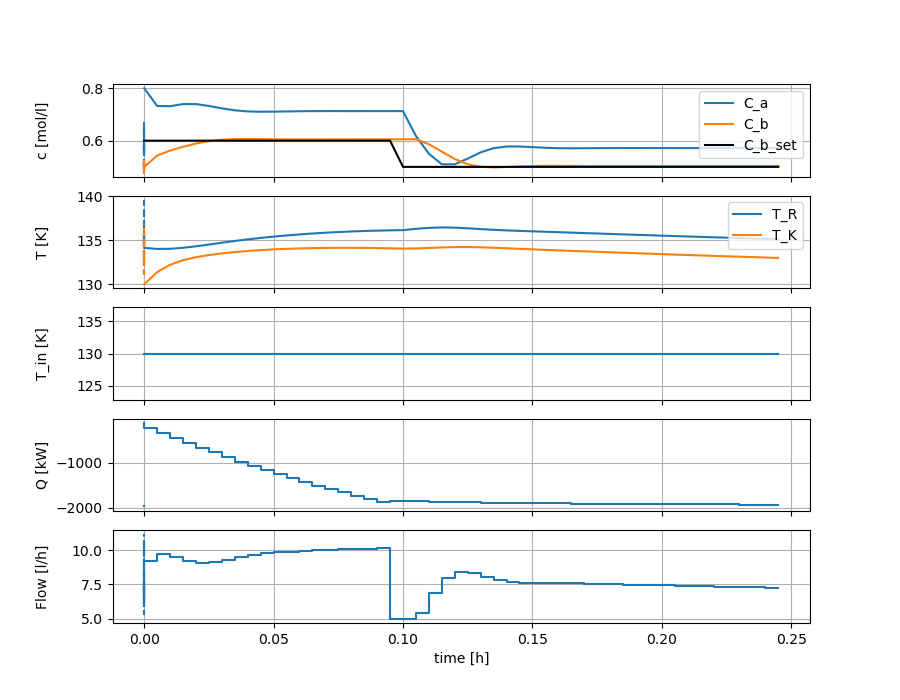

In [180]:
fig, ax = plt.subplots(5, sharex=True, figsize=(9,7))
# Configure plot:
mpc_graphics.add_line(var_type='_x', var_name='C_a', axis=ax[0], label='C_a')
mpc_graphics.add_line(var_type='_x', var_name='C_b', axis=ax[0])
mpc_graphics.add_line(var_type='_tvp', var_name='C_b_set', axis=ax[0], color='k')
mpc_graphics.add_line(var_type='_x', var_name='T_R', axis=ax[1])
mpc_graphics.add_line(var_type='_x', var_name='T_K', axis=ax[1])
mpc_graphics.add_line(var_type='_tvp', var_name='T_in', axis=ax[2])
mpc_graphics.add_line(var_type='_u', var_name='Q_dot', axis=ax[3])
mpc_graphics.add_line(var_type='_u', var_name='F', axis=ax[4])
ax[0].set_ylabel('c [mol/l]')
ax[1].set_ylabel('T [K]')
ax[2].set_ylabel('T_in [K]')
ax[3].set_ylabel('Q [kW]')
ax[4].set_ylabel('Flow [l/h]')
ax[4].set_xlabel('time [h]')

# Add labels
ax[0].legend()
label_lines = []
label_lines += mpc_graphics.result_lines['_x', 'C_a']
label_lines += mpc_graphics.result_lines['_x', 'C_b']
label_lines += mpc_graphics.result_lines['_tvp', 'C_b_set']

ax[0].legend(label_lines, ['C_a', 'C_b', 'C_b_set'])
label_lines = mpc_graphics.result_lines['_x', 'T_R']+mpc_graphics.result_lines['_x', 'T_K']
ax[1].legend(label_lines, ['T_R', 'T_K'])

fig.align_ylabels()

In [178]:
import ipywidgets as widgets

interactive(children=(IntSlider(value=0, description='t_ind', max=49), Output()), _dom_classes=('widget-intera…

<IPython.core.display.Javascript object>


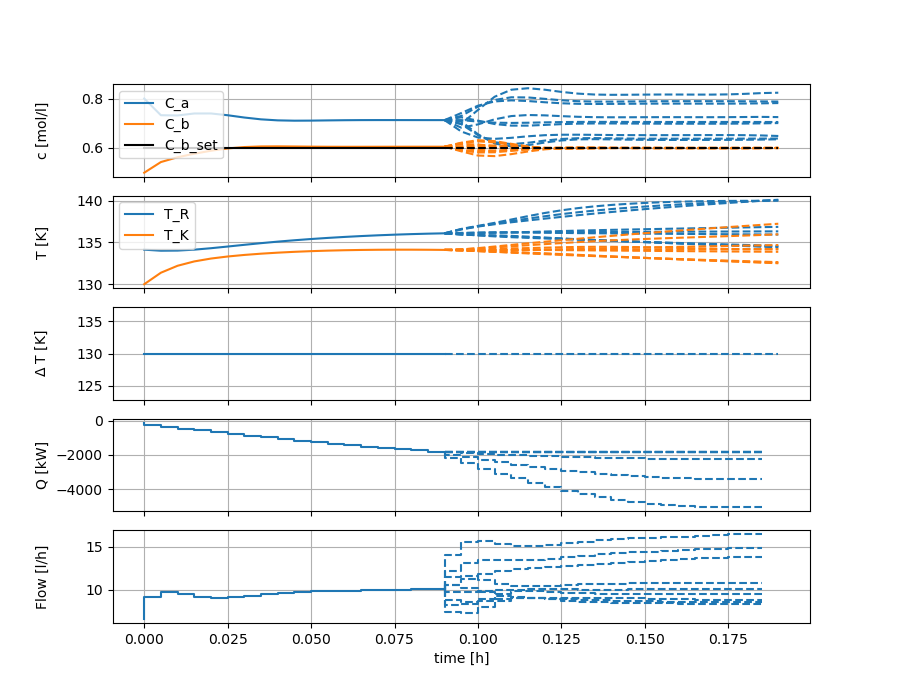

In [179]:
def plot_anim(t_ind=0):
    mpc_graphics.plot_results(t_ind=t_ind)
    mpc_graphics.plot_predictions(t_ind=t_ind)
    mpc_graphics.reset_axes()

    
widgets.interact(plot_anim,
        t_ind = widgets.IntSlider(value=0,min=0,max=N_sim-1)
        )

fig

After importing the necessary package:

In [31]:
from matplotlib.animation import FuncAnimation, ImageMagickWriter

We obtain the animation with:

In [32]:
def update(t_ind):
    print('Writing frame: {}.'.format(t_ind), end='\r')
    mpc_graphics.plot_results(t_ind=t_ind)
    mpc_graphics.plot_predictions(t_ind=t_ind)
    mpc_graphics.reset_axes()
    lines = mpc_graphics.result_lines.full
    return lines

n_steps = mpc.data['_time'].shape[0]


anim = FuncAnimation(fig, update, frames=n_steps, blit=True)

gif_writer = ImageMagickWriter(fps=5)
anim.save('anim_CSTR.gif', writer=gif_writer)

![cstranim](anim_CSTR.gif "cstr")

Recorded trajectories are shown as solid lines, whereas predictions are dashed. We highlight the nominal prediction with a thicker line.